# Домашка №1

In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет
Конкретно эта часть кода понадобится нам один раз за курс и будет только в этой домашке

In [ ]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Переводим его в два класса
Это нужно для упрощения задачи до бинарной классификации. В этой домашке мы будем отличать две цифры: 3 и 7.

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных
Далее в курсе мы поговорим о том, что это такое более подробно, а дальше в этой тетрадке будет несколько полезных деталей.  
Пока что будет достаточно понимать, что мы обернули наши данные в некоторую абстракцию, итерация по которой дает нам батчи данных из нашего датасета.  

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

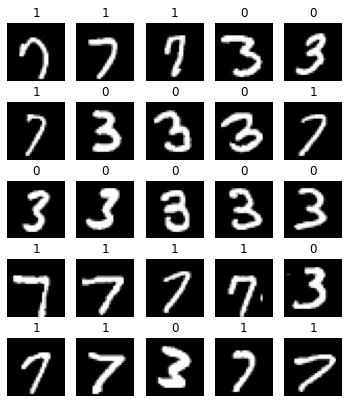

In [6]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Итерация по датасету
- x - батч с данными
- y - батч с таргетами к этим данным

In [7]:
for x, y in train_loader:
  break

### train_loader это итератор, при проходе по которому будут выдаваться батчи данных

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [8]:
x.shape

torch.Size([128, 1, 28, 28])

## Просто выпрямим нашу матрицу в один вектор
То есть каждая фича в векторе это значение пикселя
Для нашей игрушечной задачи этого будет достаточно

In [9]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
Это перевод торчового тензора (некоторая абстракция, о которой мы будем говорить позже на курсе) в numpy массив

In [10]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

### Размерность
- количество примеров в батче
- количество фичей

In [11]:
x.shape

(128, 784)

# Таргеты
- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7

In [12]:
y.shape

(128,)

# Задание

### Шаги:
1. Задайте обучаемые параметры (TIP: np.random.rand) 
1. Задайте скорость обучения (подойдет 0.01, но можете попробовать другие и посмотреть что меняется), количество эпох (полных проходов по датасету) 
1. Сделайте линейную трансформацию через первый слой (первый набор весов)
1. Примените какую-нибудь нелийную функцию активации (tanh, relu) 
1. Сделайте линейную трансформацию через второй слой (второй набор весов) 
1. Примените сигмоиду 
1. Рассчитайте функцию потерь (бинарная кросс энтропия), не забудьте усреднить по батчу 
1. Сохраняйте значения функции потерь в массив losses 
1. Возьмите производные от функции потерь к каждому обучаемому параметру [видео про производные](https://youtu.be/tZ0yCzWfbZc)
1. Обновите веса w1, b1, w2, b2 с помощью градиентного спуска
1. Нарисуйте график функции потерь

In [18]:
learning_rate = 0.01
epochs = 7

w1 = 0.01 * np.random.randn(784, 64)
b1 = np.zeros((1, 64)) 

w2 = 0.01 * np.random.randn(64, 1)
b2 = [0]

losses = []
accuracies = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        
        # forward
        linear_trnsf1 = np.dot(x, w1) + b1 # 1st linear transformation
        hidden_outputs = np.maximum(0, linear_trnsf1) # ReLU applied
        linear_trnsf2 = np.dot(hidden_outputs, w2) + b2 # 2nd linear transformation
        probabilities = 1/(1+np.exp(-linear_trnsf2)) # sigmoid applied
      
        # рассчет bce
        samples_losses = -y*np.log(probabilities)-(1-y)*np.log(1-probabilities) # get losses for all samples
        batch_loss = np.mean(samples_losses) # final mean loss for a batch
        losses.append(batch_loss)

        predictions = np.where(probabilities > 0.5, 1, 0)
        accuracy = np.mean(predictions==y)
        accuracies.append(accuracy)

        # backward

        # BCE derivative
        batch_size = len(probabilities)
        # claculate gradient w.r.t sigmoid output
        bce_bkwd = ((-y.T / probabilities.T) + (1-y.T)/(1-probabilities.T))
        bce_bkwd = (bce_bkwd / batch_size).T # normalize gradient

        # sigmoind derivative 
        sigm_bkwd = probabilities *(1-probabilities) * bce_bkwd

        # dense layer 2 derivatives
        w2_bkwd = np.dot(hidden_outputs.T, sigm_bkwd)
        b2_bkwd = np.sum(sigm_bkwd, axis=0, keepdims=True)
        hidden_outputs_bkwd = np.dot(sigm_bkwd, w2.T)

        # ReLU derivative 
        relu_bkwd = np.where(linear_trnsf1 <= 0, 0, hidden_outputs_bkwd)

        # dense layer 2 derivatives
        w1_bkwd = np.dot(x.T, relu_bkwd)
        b1_bkwd = np.sum(relu_bkwd, axis=0, keepdims=True)
        inputs_bkwd = np.dot(relu_bkwd, w1.T)

        # gradient descent

        w1 += - learning_rate * w1_bkwd
        b1 += -learning_rate * b1_bkwd

        w2 += - learning_rate * w2_bkwd
        b2 += -learning_rate * b2_bkwd

    print(f'Accuracy: {accuracies[-1]}')
    print(f'loss: {losses[-1]}')

Epoch: 1
Accuracy: 0.9629629629629629
loss: 0.21591882135305743
Epoch: 2
Accuracy: 0.9444444444444444
loss: 0.14736887310758973
Epoch: 3
Accuracy: 0.9814814814814815
loss: 0.05710354387566322
Epoch: 4
Accuracy: 0.9351851851851852
loss: 0.1212103219141957
Epoch: 5
Accuracy: 0.9629629629629629
loss: 0.1080669268172433
Epoch: 6
Accuracy: 0.9814814814814815
loss: 0.05541135965633805
Epoch: 7
Accuracy: 0.9722222222222222
loss: 0.07113855074989896


## График функции потерь
Нужно получить значение лосса ниже 0.1 (на графике)

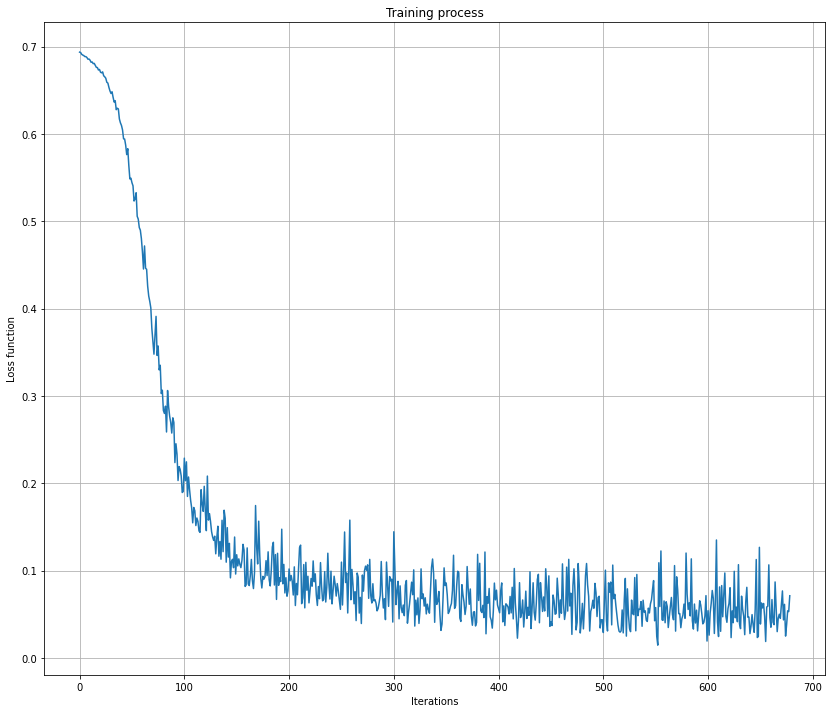

In [19]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

In [20]:
np.mean(losses)

0.13908666083757346